# Least squares fit using Ohm’s law

We analyse the file current measurements.txt, which contains a set of six measurements of the current as a
function of the voltage to measure the resistance, R. The first column is the voltage value in
V and the second column is the current value in A. Here, we define the functions which will be of importance for the whole exercise:

First, we load the necessary libraries:

In [46]:
import numpy as np
import scipy.optimize as opt
from matplotlib import pyplot as plt
from scipy.stats import chi2 as chi2sp

And load the data:

In [47]:
def load_data(file):

    return np.loadtxt(file)

data = load_data("current_measurements.txt")

In [48]:


def current_ohmslaw_bias(U, R, bias=None):
    """Calculate the current according to Ohm's Law given the voltage U and resistance R with a bias.

    Ohm's Law states that the current is given by:

    .. math::

        I = \frac{U}{R}

    We can add a bias to the current by adding a constant to the voltage:

    .. math::

        I = \frac{U + bias}{R}

    Args:
        U (float, array): The measured voltage.
        R (float, array): The resistance.
        bias (float, array): The bias to add to the voltage. If None, no bias is added.

    Returns:
        float or array: Value of the linear function. Shape is the broadcast shape of
            the inputs.
    """
    if bias is None:
        bias = 0  # with this, we can also use the function without bias.

    return current_ohmslaw(U=U, R=R) + (bias / R)

## Consistent uncertainty
To start, the uncertainty for each measurement is assumed to be consistent, i.e., 0.2A.

#### Explorative Visualitation
Let's plot the current measurments as a function of the voltage:

Text(0, 0.5, 'Current [A]')

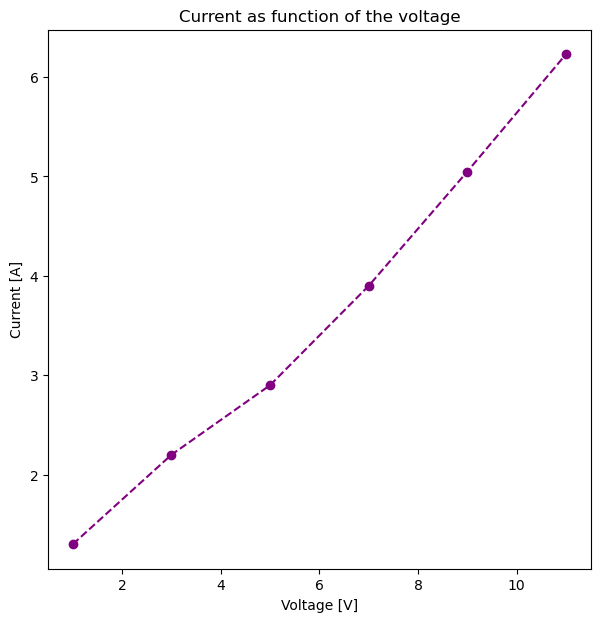

In [49]:
plt.figure(figsize = (7, 7))
plt.plot(data[:, 0], data[:, 1], marker = "o", linestyle = "--", color = "purple")
title = "Current as function of the voltage"
plt.title(title)
plt.xlabel("Voltage [V]")
plt.ylabel("Current [A]")

First, we will write a function to evaluate ohm's law and the $\chi^2$ as a function of the resistance, R to later use this relationship for least squares fitting. To do this we need to define several helper functions:


In [50]:
def current_ohmslaw(U, R):
    r"""Calculate the current according to Ohm's Law given the voltage U and resistance R.

    Ohm's Law states that the current is given by:

    .. math::

        I = \frac{U}{R}

    Args:
        U (float, array): The measured voltage.
        R (float, array): The resistance.

    Returns:
        float or array: Value of the linear function. Shape is the broadcast shape of
            the inputs.
    """
    return U / R

def chi2(x, y, err, offset = 0):
    """Calculate the chi2 statistic for a dataset and its predictions.

    Args:
        x (array): The first data set.
        y (array): Predicted values for the first data set.
        err (array): The error on the measurements of the first data set.

    Returns:
        float: The chi2 statistic.
    """

    chi_sq = 0

    for j in range(len(x)):

        chi_sq += ((x[j] - y[j]) ** 2) / (err[j] ** 2)

    return  chi_sq + offset

def chi2_toR(R):
    """Calculate chi2 in dependence of the resistance."""

    # Here is your code for exercise 1b.
    data = load_data("current_measurements.txt")  # load it from file for example
    voltage = data[:, 0]  # etc.
    current = data[:, 1]
    current_pred = current_ohmslaw(U = voltage, R = R)
    error = np.ones_like(current) * 0.2
    chi2val = chi2(x = current, y = current_pred, err = error)


    return chi2val


We can then use this `chi2_toR` function to find the best fit value of R by plotting the $\chi^2$ - value as a function of the resistance and find its minimum:

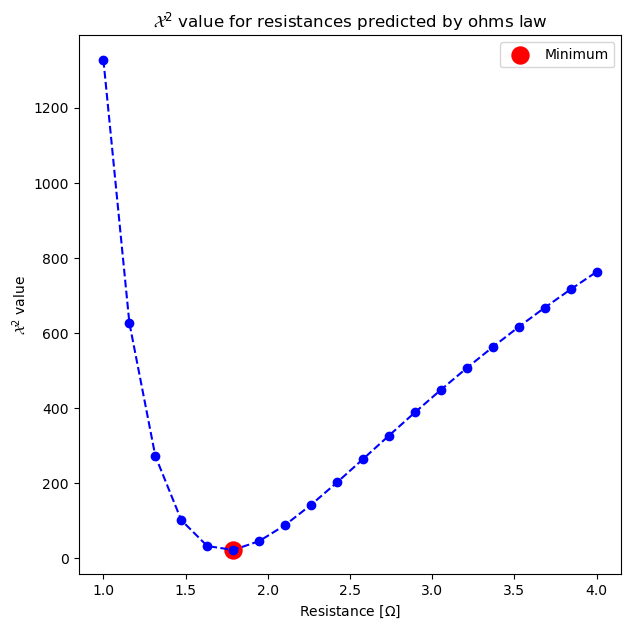

In [51]:
    resistances = np.linspace(start = 1, stop = 4, num = 20) # number of steps = length of input data, data_range(0, 2)
    chi2val = np.array([chi2_toR(R = R) for R in resistances]) # store chi values
    # now find the minimum
    minchi2 = min(chi2val)
    minindex = np.argwhere(chi2val == minchi2)[0][0]
    # plot the resulting chi2val array
    plt.figure(figsize = (7, 7))
    plt.plot(resistances, chi2val, marker = "o", linestyle = "--", color = "blue")
    plt.scatter(resistances[minindex], minchi2, c = "red", label = "Minimum", s = 150)
    title = "$\mathcal{X}^2$ value for resistances predicted by ohms law"
    plt.title(title)
    plt.xlabel("Resistance [$\Omega$]")
    plt.ylabel("$\mathcal{X}^2$ value")
    plt.legend()
    plt.savefig("1c_" + title.replace(" ", "_").replace("$\mathcal{X}^2$", "Chi2") + ".png", dpi = 150)

Now, we can compare this value with the formula of linear regression defined below:

In [52]:
def lin_analytical(x, y):
    """Calculcates analytical result by taking advantage of regression properties"""

    m_hat = (np.mean(x * y) - np.mean(x) * np.mean(y)) / (np.mean(x ** 2) - np.mean(x) ** 2)

    return m_hat

# Calculate analytical result
voltage = data[:, 0]  # etc.
current = data[:, 1]
# current_pred = current_ohmslaw(U = voltage, R = R)
m_hat = lin_analytical(x = voltage, y = current)
chi_R = 1.79 # obtained from exercise 1c)
lin_R = 1 / m_hat


We find that this is not the case, as best R obtained by **$\chi^2$ is 1.79 and by analytics is 2.05**.
Hence, they don't  agree with the delta of *0.26* being bigger than the uncertainty on best R due to the rule of 68% coverage.


Furthermore, reading of the uncertainties on R (red) by using the $\Delta(\chi^2) = 1$ rule (pink), we can check whether the analytical formula applies here:

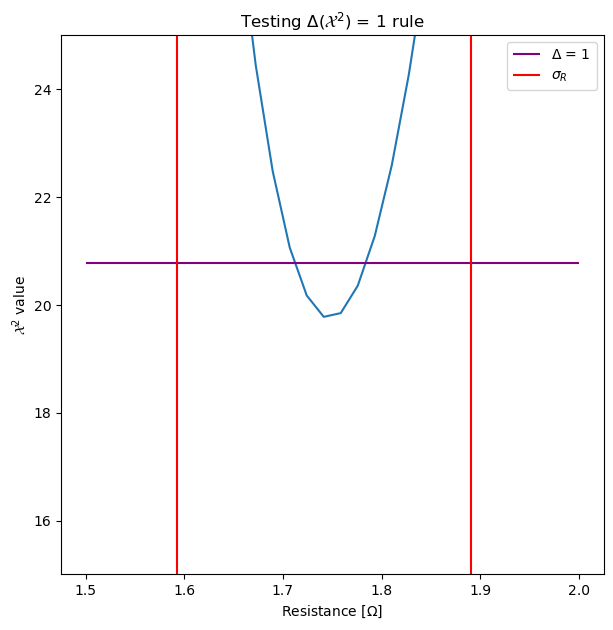

In [53]:
resistances = np.linspace(start=1.5, stop=2, num=30)  # number of steps = length of input data, data_range(0, 2)
chi2val = np.array([chi2_toR(R=R) for R in resistances])
minchi2 = min(chi2val)
minindex = np.argwhere(chi2val == minchi2)[0][0]
min_R = resistances[minindex]
err = np.std(resistances)
delta_1 = minchi2 + 1

plt.figure(figsize=(7, 7))
plt.plot(resistances, chi2val)
plt.hlines(y = delta_1, xmin = min(resistances), xmax = max(resistances),
           label = "$\Delta$ = 1", color = "purple")
plt.vlines(x= [min_R + err, min_R - err], ymin=[15] * 2, ymax=[25] * 2,
           label = "$\sigma_{R}$", color = "red")
plt.ylim(15, 25)
title = "Testing $\Delta$($\mathcal{X}^2$) = 1 rule"
plt.xlabel("Resistance [$\Omega$]")
plt.ylabel("$\mathcal{X}^2$ value")
plt.title(title)
plt.legend()

As visualized in this graphic, the intersection of the delta rule with the $\chi^2$-function is not close to the intersection of the delta rule and the plotted uncertainties. Thus they do still NOT agree!

<Figure size 700x700 with 1 Axes>

## Varying uncertainties
In a next step we will let the uncertaities vary in the data. The uncertainty is given in the third column of the file. As for the analysis of data with consistent uncertainty we have to define helper functions again to use $\chi^2$:

In [54]:
def chi2_toR_bias(R):
    """Calculate chi2 in dependence of the resistance. Same as above but loads different data."""
    data = load_data("current_measurements_uncertainties.txt")
    voltage = data[: ,0]
    current = data[:, 1 ]
    current_err = data[:, 2]
    current_pred = current_ohmslaw(U = voltage, R = R)
    chi2val = chi2(x = current, y = current_pred, err = current_err)

    return chi2val

We compute, again, the $chi^2$ values as a function of the resistance. We do this in a conditional function to have the possibility to reuse it for returning the value of the R with the lowest $\chi^2$ value. In the plot we see that it is the same data.

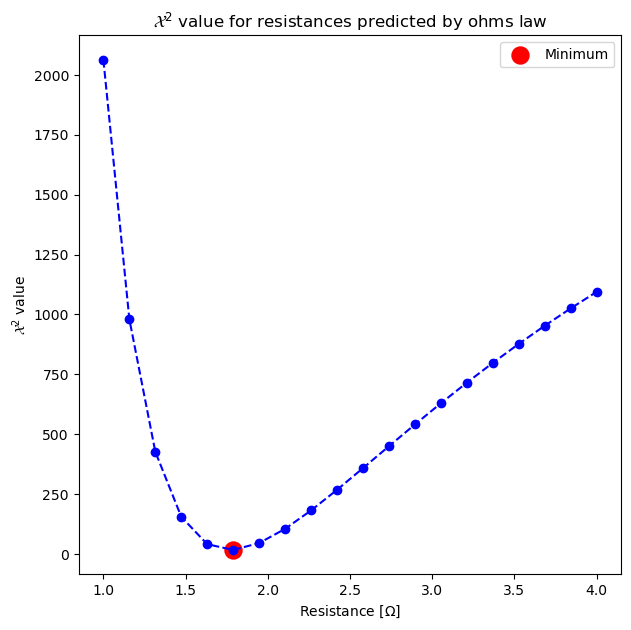

In [55]:
def return_bestR(best_R = False):
    # Here is your code for exercise 1c.
    resistances = np.linspace(start = 1, stop = 4, num = 20) # number of steps = length of input data, data_range(0, 2)
    chi2val = np.array([chi2_toR_bias(R = R) for R in resistances])
    minchi2 = min(chi2val)
    minindex = np.argwhere(chi2val == minchi2)[0][0]

    if best_R == False:
        # plot the resulting chi2val array
        plt.figure(figsize = (7, 7))
        plt.plot(resistances, chi2val, marker = "o", linestyle = "--", color = "blue")
        plt.scatter(resistances[minindex], minchi2, c = "red", label = "Minimum", s = 150)
        title = "$\mathcal{X}^2$ value for resistances predicted by ohms law"
        plt.title(title)
        plt.xlabel("Resistance [$\Omega$]")
        plt.ylabel("$\mathcal{X}^2$ value")
        plt.legend()
    else:

        return resistances[minindex]

return_bestR()

Let's overlay this fit of R with our meaurement data:

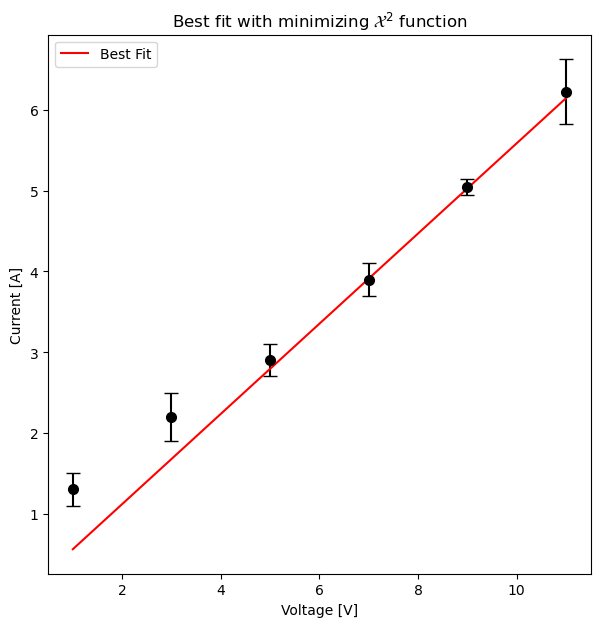

In [56]:
data = load_data("current_measurements_uncertainties.txt")
best_fit = current_ohmslaw(U = data[:, 0], R = return_bestR(best_R=True))
# plot measurements and fit with obtained best R
plt.figure(figsize=(7, 7))
plt.errorbar(x = data[:, 0], y = data[:, 1], yerr = data[:, 2], linestyle = "",
             fmt = "ko", capsize = 5, markersize = 7, ecolor = "k")
plt.plot(data[:, 0], best_fit, color = "red",label = "Best Fit")
title = "Best fit with minimizing $\mathcal{X}^2$ function"
plt.xlabel("Voltage [V]")
plt.ylabel("Current [A]")
plt.title(title)
plt.legend()

We see that this fit goes exactly through 4/6 datapoints, yet is remarkably far from the first two. This implies **overfitting** to the data, as the fit is best when it touches all uncertainty bars!

Again, reading of the uncertainties on R (red) by using the $\Delta(\chi^2) = 1$ rule (pink), we can check whether the analytical formula applies here:

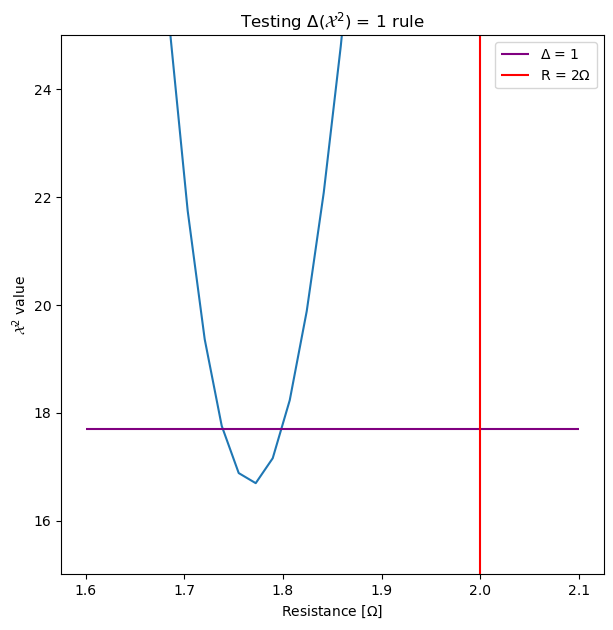

In [57]:
resistances = np.linspace(start=1.6, stop=2.1, num=30)  # number of steps = length of input data, data_range(0, 2)
chi2val = np.array([chi2_toR_bias(R=R) for R in resistances])
minchi2 = min(chi2val)
minindex = np.argwhere(chi2val == minchi2)[0][0]
min_R = resistances[minindex]
err = np.std(resistances)
delta_1 = minchi2 + 1

plt.figure(figsize=(7, 7))
plt.plot(resistances, chi2val)
plt.hlines(y = delta_1, xmin = min(resistances), xmax = max(resistances),
           label = "$\Delta$ = 1", color = "purple")
plt.vlines(x= 2, ymin=15, ymax=25,
           label="R = 2$\Omega$", color="red")

plt.ylim(15, 25)
title = "Testing $\Delta$($\mathcal{X}^2$) = 1 rule"
plt.xlabel("Resistance [$\Omega$]")
plt.ylabel("$\mathcal{X}^2$ value")
plt.title(title)
plt.legend()


As visualized in this graphic, the intersections of the delta rule with the chi2 function DO NOT agree with R = 2 Ohm, as they describe an approximate uncertainty of +/- 0.05 Ohm on the central value of 1.78 (no 68 % coverage).


The $\chi^2$ function has been adjusted to include a constant offset parameter. This offset parameter (with a default value of 0) has been incorporated into the "Ohms law" function. The bias value ($\epsilon_{bias}$) is set at 0.7A, following the lecture. Consequently, the recalculated R value for the best fit has been computed along with its associated uncertainty.


In [58]:
def current_ohmslaw_bias(U, R, bias=None):
    """Calculate the current according to Ohm's Law given the voltage U and resistance R with a bias.

    Ohm's Law states that the current is given by:

    .. math::

        I = \frac{U}{R}

    We can add a bias to the current by adding a constant to the voltage:

    .. math::

        I = \frac{U + bias}{R}

    Args:
        U (float, array): The measured voltage.
        R (float, array): The resistance.
        bias (float, array): The bias to add to the voltage. If None, no bias is added.

    Returns:
        float or array: Value of the linear function. Shape is the broadcast shape of
            the inputs.
    """
    if bias is None:
        bias = 0  # with this, we can also use the function without bias.

    return current_ohmslaw(U=U, R=R) + (bias / R)

def chi2_toR_bias(R, bias = 0):
    data = load_data("current_measurements_uncertainties.txt")
    voltage = data[: , 0]
    current = data[:, 1 ]
    current_err = data[:, 2]
    current_pred = current_ohmslaw_bias(U = voltage, R = R, bias = bias)
    chi2val = chi2(x = current, y = current_pred, err = current_err, offset = bias)

    return chi2val

The question remains: does the new R value now align with the anticipated R = 2 Ω value?

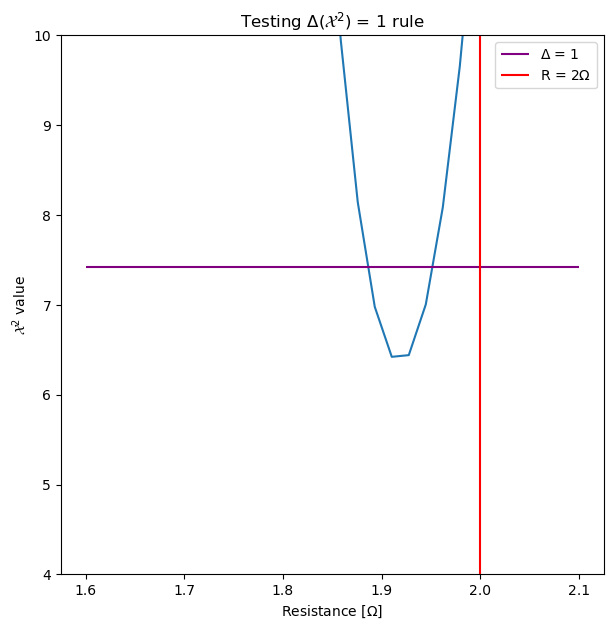

In [59]:
bias = 0.7
resistances = np.linspace(start=1.6, stop=2.1, num=30)  # number of steps = length of input data, data_range(0, 2)
chi2val = np.array([chi2_toR_bias(R=R, bias = bias) for R in resistances])
minchi2 = min(chi2val)
minindex = np.argwhere(chi2val == minchi2)[0][0]
min_R = resistances[minindex]
err = np.std(resistances)
delta_1 = minchi2 + 1
plt.figure(figsize=(7, 7))
plt.plot(resistances, chi2val)
plt.hlines(y = delta_1, xmin = min(resistances), xmax = max(resistances),
           label = "$\Delta$ = 1", color = "purple")
plt.vlines(x= 2, ymin=0, ymax=15,
           label="R = 2$\Omega$", color="red")

plt.ylim(4, 10)
title = "Testing $\Delta$($\mathcal{X}^2$) = 1 rule"
plt.xlabel("Resistance [$\Omega$]")
plt.ylabel("$\mathcal{X}^2$ value")
plt.title(title)
plt.legend()

As visualized in this graphic, the intersections of the delta rule with the $\chi^2$-function DO NOT agree with R = 2 $\Omega$ (no 68 % coverage), as they describe an approximate uncertainty of +/- 0.05 $\Omega$ ($1\sigma$) on the central value of 1.92.


Next, we compare the $\chi^2 / ndf$ with and without the bias offset and calculate the goodness-of-fit
probability for both cases.

In [60]:
bias = 0.7
resistances = np.linspace(start=1.5, stop=2.5, num=30)  # number of steps = length of input data, data_range(0, 2)
chi2val_nobias = np.array([chi2_toR_bias(R=R) for R in resistances])
chi2val_bias = np.array([chi2_toR_bias(R=R, bias = bias) for R in resistances])
minchi2_nobias = min(chi2val_nobias)
minchi2_bias = min(chi2val_bias)

ndf = 5 # slope only
gof_nobias  = minchi2_nobias / ndf
gof_bias = minchi2_bias / (ndf - 1)

p_bias, p_nobias = chi2sp.cdf(minchi2_bias, gof_bias),  chi2sp.cdf(minchi2_nobias, gof_nobias)

print("\n2F:\nBoth are `bad` fits, as their probability for goodness of fit is {:.3f} with bias\n"
      "and {:.3f} without. These values are far bigger from the mean probability of the CDF at 0.5,\n"
      "implying OVERFITTING.".format(p_bias,
                                     p_nobias))


2F:
Both are `bad` fits, as their probability for goodness of fit is 0.973 with bias
and 0.999 without. These values are far bigger from the mean probability of the CDF at 0.5,
implying OVERFITTING.


Let's use the `scipy.optimize.curve_fit` method to fit the function to the data and optimise both the R and $\epsilon_{bias}$ parameters simultaneously. Visually, this fit improves further as the line touches all errorbar compared to the $\chi^2$ one before:

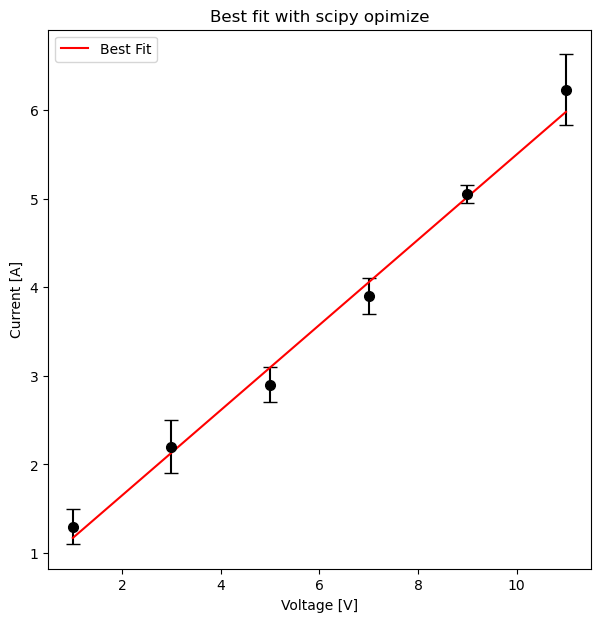

In [64]:
def curve_fit(data):
    voltage = data[: , 0]
    current = data[:, 1 ]
    current_err = data[:, 2]

    popt, pcov = opt.curve_fit(current_ohmslaw_bias, xdata = voltage, ydata = current,
                               sigma = current_err)

    return popt, pcov

# fit with scipy.optimze
popt, pcov = curve_fit(data)

# calculate fitted line
best_fit = current_ohmslaw_bias(U = data[:, 0], R = popt[0], bias = popt[1])
# plot measurements and fit with obtained best R
plt.figure(figsize=(7, 7))
plt.errorbar(x = data[:, 0], y = data[:, 1], yerr = data[:, 2], linestyle = "",
             fmt = "ko", capsize = 5, markersize = 7, ecolor = "k")
plt.plot(data[:, 0], best_fit, color = "red",label = "Best Fit")
title = "Best fit with scipy opimize"
plt.xlabel("Voltage [V]")
plt.ylabel("Current [A]")
plt.title(title)
plt.legend()


Finally, we use the covariance matrix returned by the `scipy.optimize.curve_fit` to calculate the uncertainties on R and $\epsilon_ {bias}$ and their correlation coefficient. How does the uncertainty on R compared to your answer in e)?

In [65]:
def correlation(data, plot = True):
    popt, pcov = curve_fit(data)
    cov_xy = pcov[0, 1]
    std_x = pcov[0, 0] ** 0.5 # uncertainty of bias
    std_y = pcov[1, 1] ** 0.5 # uncertr

    rho = cov_xy / (std_x * std_y)

    print("Conclusion: \n The resulting covariance matrix proposes R = {:.2f} +/- {:.2f} and "
          "e_bias = {:.1f} +/- {:.1f}, resulting in a correlation coefficient of {:.2f}.\n"
          "Uncertainty on R is ~factor 5 lower than described in 2e, implying a"
          "a `tigher` chi2 dip around the minimum than visualized in the last test of the delta rule "
          "".format(popt[0], std_x, popt[1], std_y, rho))


correlation(data)

Conclusion: 
 The resulting covariance matrix proposes R = 2.08 +/- 0.08 and e_bias = 1.4 +/- 0.4, resulting in a correlation coefficient of 0.94.
Uncertainty on R is ~factor 5 lower than described in 2e, implying aa `tigher` chi2 dip around the minimum than visualized in plot 2e 
